In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("housing.csv")

In [4]:
data
# income catagory is defined in bins depending upon catagory
# now we devide it into stratifiedspltit because 
# different catagories is with diferent portion

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
data["income_cat"] = pd.cut(data["median_income"],
                               bins = [0,1.5, 3.0, 4.5, 6.0, np.inf],
                                labels=[1,2,3,4,5])

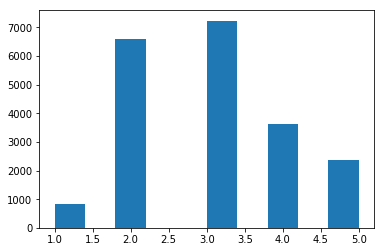

In [6]:
data["income_cat"].hist()
plt.grid(False)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state = 42)

In [8]:
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

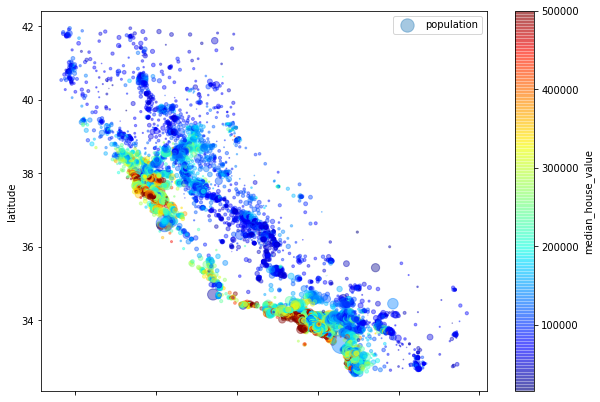

In [9]:
# plotting the data to visualize
data.plot(kind = "scatter" , x="longitude" , y = "latitude",alpha = 0.4,
          s = data["population"]/100 , label = "population" , figsize = (10,7),
          c = "median_house_value" , cmap = plt.get_cmap("jet") , colorbar= True,
         )
plt.legend()

In [10]:
# looking for correlation
corr_mat = data.corr()

In [11]:
corr_mat["median_house_value"]

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

In [12]:
# there is a strong relation between median_income

In [13]:
# preparing to train my model
housing  = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [14]:
# data cleaning there is a lot of na in total_bedrooms

In [15]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity",axis = 1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [16]:
# now the text attribute in ocean proximity doesnot work well in ml algo

housing_cat = housing[["ocean_proximity"]]

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [17]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [18]:
# feature scaling 
from sklearn.preprocessing import StandardScaler

In [19]:
#pipelining 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [20]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('std_scaler' , StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [21]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.42069842,
        -0.61493744, -0.95445595],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -1.02222705,
         1.33645936,  1.89030518],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.0933178 ,
        -0.5320456 , -0.95445595],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.71315642,
        -0.3167053 , -0.00620224],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.37545069,
         0.09812139, -0.00620224],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.3777909 ,
        -0.15779865, -0.00620224]])

In [22]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

In [23]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [26]:
print(lin_reg.predict(some_data_prepared))

[205841.96139906 329060.05217695 205219.96047357  61859.01340291
 196908.23636333]


In [27]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [28]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68867.01067610044

In [29]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [30]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse
# overfitting

0.0

In [31]:
#evalution with Cross_validation

from sklearn.model_selection import cross_val_score

In [32]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [33]:
def score(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [34]:
score(tree_rmse_scores)

Scores: [67491.02819964 67834.85133213 73190.01987795 70285.88840631
 68863.6710526  74502.67325261 65910.79404812 70078.5550537
 69570.45554484 69564.37993034]
Mean: 69729.23166982204
Standard deviation: 2432.5906305656727


In [35]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-scores)

In [36]:
score(lin_rmse_scores)

Scores: [67621.36459192 67050.2893707  68159.77945126 74185.17069359
 68112.25073467 71610.00721757 65235.24278175 68160.85292722
 72191.44396288 68163.77349381]
Mean: 69049.01752253594
Standard deviation: 2581.3240040191663


In [37]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

D:\anconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-scores)

In [39]:
score(forest_rmse_scores)

Scores: [51645.11103967 48158.49506966 51023.96359139 51367.84303194
 52832.86428971 56359.2123025  51416.27650165 51376.2690087
 52968.71511357 50906.78911627]
Mean: 51805.553906506146
Standard deviation: 1960.0247518185488


In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [41]:
final_model = grid_search.best_estimator_

In [42]:
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

In [43]:
y_test

5241     500001.0
10970    240300.0
20351    218200.0
6568     182100.0
13285    121300.0
           ...   
20519     76400.0
17430    134000.0
4019     311700.0
12107    133500.0
2398      78600.0
Name: median_house_value, Length: 4128, dtype: float64

In [44]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,<1H OCEAN,5
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,<1H OCEAN,4
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,<1H OCEAN,3
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,INLAND,3
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,INLAND,3
...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,INLAND,2
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,NEAR OCEAN,2
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,<1H OCEAN,4
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,INLAND,4


In [45]:
X_test_pre = full_pipeline.transform(X_test)

In [46]:
X_predict = final_model.predict(X_test_pre)

In [47]:
np.sqrt(mean_squared_error(y_test,X_predict))

48388.28480074939

In [48]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])